# Advanced Machine Learning - programming assignment 3

*Due: Friday January 10*

*Grading: 10 points total*

**Please fill in:**
* Mahshid Jafar Tajrishi (2931788)
* Konstantinos Zavantias (7456123)

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [37]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

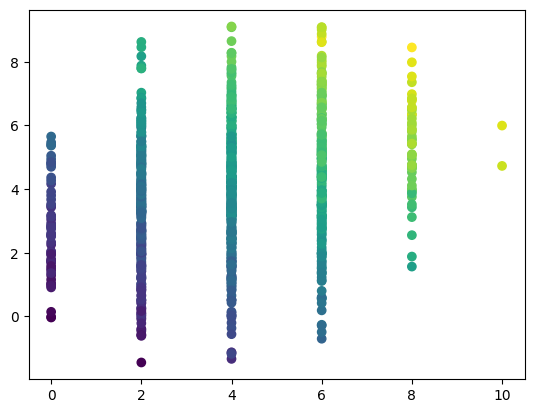

In [38]:
plt.scatter(x, y, c=z)
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

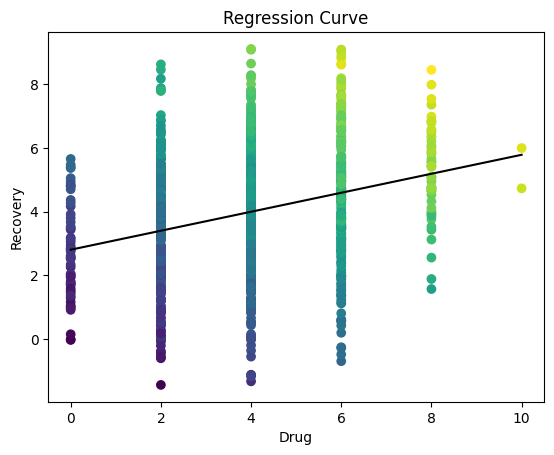

In [39]:
# Your code here
from sklearn.linear_model import LinearRegression
model = LinearRegression()
#reshape for sklearn fitting
x_r = x.reshape(-1,1)
model.fit(x_r, y)

#initialization of values for linspace
start = x.min()
stop = x.max()
# it is +1 to include endpoints
num_of_samples = int(stop-start+1)
#linspace 
x_range = np.linspace(start, stop, num_of_samples)
x_range = x_range.reshape(-1,1)
#y values prediction based on trained model x_range
pred_y = model.predict(x_range)

#result ploting
plt.scatter(x, y, c=z)
plt.plot(x_range, pred_y, color="black")
plt.title("Regression Curve")
plt.xlabel("Drug")
plt.ylabel("Recovery")
plt.show()


Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

*Your answer here*

The endogenous variables have been mentioned in the beginning and they are the following three genetics, drug dosage, and outcome (their order is based on their appearance on the first code):
#### Z: Genetics
##### formula: 
F(Z) = 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)

As it is observed from the formula genetics aren't related to the other endogenous variables directly, and this is validated also in real-world terms as genetic information is different between people and independent of drug dosage or outcome.

#### X: Drug Dosage
##### formula: 
x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
F(X) = np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)

Drug dosage is dependent on genetics (z) and random noise. This is true as in the real-world the dosage of a drug is determined by the individual's genetic factors. For example, each one needs a different dose of a drug because of their weight or clinical history or even more some can't take a drug because they are allergic to a substance of the drug. 

#### Y: Recovery Outcome
##### formula: 
F(Y) = 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

Following logic and the formula for the outcome, the outcome is dependent on both genetics and drug dosage. This happens because genetics can influence that recovery time as each one reacts differently to a drug. Drug dosage also influences outcome as lower dosage can hold off the recovery while higher dosage can put patient in risk.




## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [40]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    # Your code here
    z = f_Z(num_samples) #generate z values as in the observational data
    y = f_Y(z, x, num_samples) #y values based on f_y
    # return (x, y, z)
    return (x, y, z) 

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [41]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

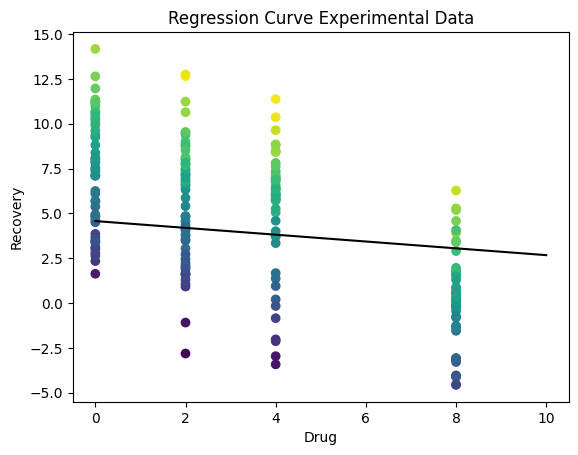

In [62]:
# Your code here
#scatter plot for experimental (exp) data
plt.scatter(x_exp, y_exp, c=z_exp)
#regression curve
plt.plot(x_range, pred_y, color="black")
plt.title("Regression Curve Experimental Data")
plt.xlabel("Drug")
plt.ylabel("Recovery")
plt.show()

**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [43]:
# Your code here
from sklearn.metrics import mean_squared_error
#reshape to fit (2d array)
x_exp = x_exp.reshape(-1,1)
#predict using previous model
exp_pred_y = model.predict(x_exp) #we use reg model from obs data to predict outcomes based on dosage of exp data
#rmse formula sqrt(Σ(Pi -0i)^2/n)
#mse mean square error calculation
mean_square_val = mean_squared_error(y_exp, exp_pred_y)
#root mse calculation
rmse = np.sqrt(mean_square_val)
print("RMSE:", rmse)

RMSE: 4.792388480387274


You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):**

**a.** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution?

**b.** For the curve you fit on the observational data to also fit well on the experimental data, a certain conditional distribution would have had to be the same for both datasets. Which conditional distribution is that? (It may or may not appear in either product decomposition.) Explain your answer.

*Your answer here*
#### A.

tThe distribution of Z remains the same between observational and experimental distribution as Z didn't have any intervention and F_y form remained the same but it used differently as the conditional relationship affected because of x was intervented

#### B.
the conditional distribution that should be the same for both datasets on the observational and experimental data is P(Y|X) as intervention   of x changes the distribution of x and also changes how y depends on x when conditioning on Z

**Question 7 (1.5 points):** What (marginal or conditional) independence must hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

*Your answer here*
Based on d-seperation, in experimental data X,Z are marginally independent because there is no path that connects X,Z. Also, both of them serve as parent nodes of the collider Y. The only way for these two variables to become dependent is to condition on Y. 

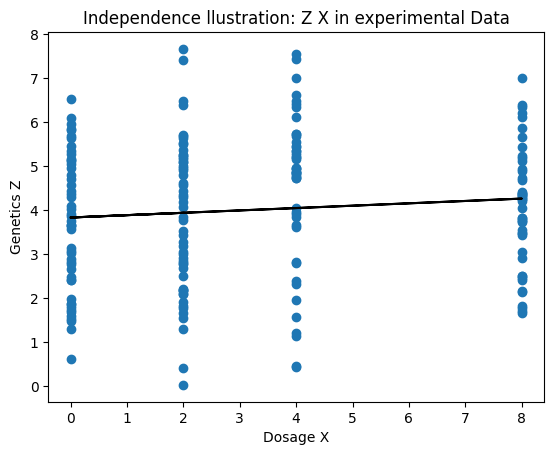

the slope of regression line is 0.05379787919337672


In [46]:
# Your code here

#plot for experimental data
plt.scatter(x_exp, z_exp)

#initialization of values for linspace
start = x_exp.min()
stop = x_exp.max()
# it is +1 to include endpoints
num_of_samples = int(stop-start+1)
#linspace 
x_range = np.linspace(start, stop, num_of_samples)
x_range = x_range.reshape(-1,1)
#y values prediction based on trained model x_range
pred_y = model.predict(x_range)

#fir linear function to the data(m=slope, b = intercept)
m,b = np.polyfit(np.squeeze(x_exp), z_exp,1)

#regression line
plt.plot(np.squeeze(x_exp), m*np.squeeze(x_exp)+b, color="black")

plt.xlabel("Dosage X")
plt.ylabel("Genetics Z")
plt.title("Independence llustration: Z X in experimental Data")
plt.show()
print(f"the slope of regression line is {m}")

**Task 8 (2 points):** Now, we will use the method of inverse probability weighting (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [69]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)
#reshape z to fit in
z = z.reshape(-1,1)
reg_logistic.fit(z,x)
#inverse probabilities
#use of predict_proba method as it provides the prob distribution over all possible outcomes of x for each z
#which is needed for IPW computation
inverse_prob = reg_logistic.predict_proba(z)
#IPW Calculation
#for each data point Wi = 1/P(X=xi|Z=zi)
#so to find all store them in list weight
weight = []
for i in range(len(x)):
    #probability of observed x[i] given z[i]
    #mapping 0,2,4,8 into 0,1,2,3
    prob = inverse_prob[i,x[i]//2]
    #inverse probability weight
    w= 1/prob 
    w = int(w)
    weight.append(w)
#list to array
weight = np.array(weight)


C:\Users\kostas\anaconda3\envs\AML_RL\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weighting each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

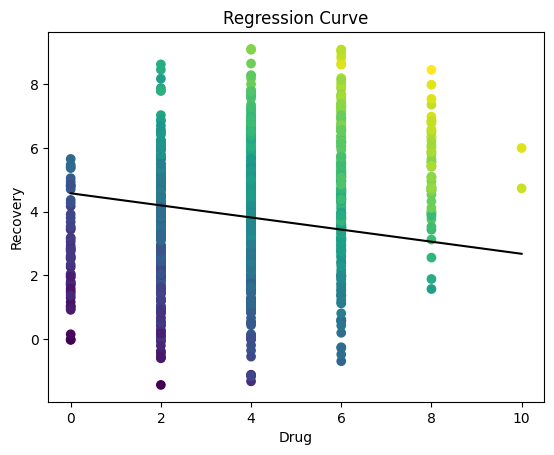

In [48]:
# Your code here
sample_weights = weight

model = LinearRegression()
#reshape for sklearn fitting
x_r = x.reshape(-1,1)
model.fit(x_r, y, sample_weights)

#initialization of values for linspace
start = x.min()
stop = x.max()
# it is +1 to include endpoints
num_of_samples = int(stop-start+1)
#linspace 
x_range = np.linspace(start, stop, num_of_samples)
x_range = x_range.reshape(-1,1)
#y values prediction based on trained model x_range
pred_y = model.predict(x_range)

#result ploting
plt.scatter(x, y, c=z)
plt.plot(x_range, pred_y, color="black")
plt.title("Regression Curve")
plt.xlabel("Drug")
plt.ylabel("Recovery")
plt.show()

**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [65]:
# Your code here
#rmse for exp data
RMSE_exp = 0 
for ix in range(0, int(x_exp.max()+1),2):
    #get y where c is equal to the current x
    idx = np.argwhere(x_exp == ix)
    iy = y_exp[idx]
    y_hat = pred_y[ix]
    if len(iy)>0:
        tot = (np.sum(iy-y_hat)**2)/len(y_exp)
        RMSE_exp += tot
RMSE_exp = np.sqrt(RMSE_exp)
print(f"RMSE:{RMSE_exp}")
        

RMSE:13.029032287362382


---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).